# Showcase of Automatic Differentiation using my torch helper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle, grad
import inspect

To use automatic differentiation of the dispersion
function and its' dependencies, all calculations
must be done using torch tensors. I've build a wrapper
function called `torch_func` which may be used as a
decorator (see example below).

**Supported Annotations**

The wrapper expects all function parameters to be
annotated; telling us whether each function parameter
is to be parsed to a torch tensor (annotated `('scalar')`),
a 3D torch tensor (annotated `('vector')`)
or is not to be parsed at all (annotated `('any')`).
Please, refer to the example below.

**Detach Annotation**

You can also use annotations to tell that the torch tensor
should also be detached before performing the calculations
(to exclude it from the backward differentation step).

**Note:** The annotations do not set requirements for the
type of the input variables, but instead provides guidence
on how to parse the input before performing the function
call. Thus, the user may give numpy arrays as input for
a function decorated with `@torch_func`.

## Examples

### Evaluating $f : \mathbb{R} \to \mathbb{R}$ using numpy array as input

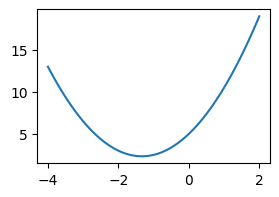

In [20]:
a, b, c = 3, 4, 5

@torch_func
def f1(x: ('scalar')):
    return 0.5 * a * (x**2) + b * x + c

# Plot torch func from -4 to 2
x_n = np.linspace(-4, 2, 100)
plt.figure(figsize=(3,2))
plt.plot(x_n, f1(x_n))
plt.show()

### $f : \mathbb{R} \to \mathbb{R}$. First and Second Derivatives of one argument.

In [2]:
# Test 1: Scalar to scalar function. f1 : R -> R
# Comparison of analytical and autograd expression.

@torch_func
def df1(x: ('scalar')):
    return a * x + b

@torch_func
def ddf1(x: ('scalar')):
    return a

x_n = np.array([3.0])
x_t = torch.tensor(x_n, requires_grad=True)

# f1_x = grad(f1(x_t), x_t, create_graph=True)[0]
# f1_xx = grad(f1_x, x_t, create_graph=True)[0]

f1_x = grad(f1(x_t), x_t)
f1_xx = grad(grad(f1(x_t), x_t), x_t)

assert f1_x == df1(x_t)
assert f1_xx == ddf1(x_t)

### $f : \mathbb{R} \to \mathbb{R}$. First and Second Derivatives of a range of scalar arguments.

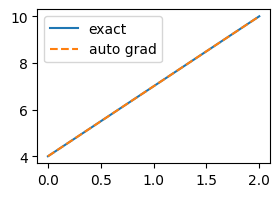

In [13]:
x_n = np.linspace(0, 2, 100)
x_t = torch.tensor(x_n, requires_grad=True)

f1_x = torch.zeros_like(x_t)
for i, _x in enumerate(x_t):
    f1_x[i] = grad(f1(_x), _x)

plt.figure(figsize=(3,2))
plt.plot(x_n, df1(x_n), '-', label='exact')
plt.plot(x_n, f1_x.detach().numpy(), '--', label='auto grad')
plt.legend()
plt.show()

### $f : \mathbb{R}^3 \to \mathbb{R}$. First and Second Derivatives of one vector argument.

In [4]:
def grad_vector_input(output, input):
    if output.shape[-1] == 1:
        return grad(output, input)
    else:
        return torch.stack([grad(f, input) for f in output])

In [5]:
@torch_func
def f2(x: ('vector')):
    return a * inner_product(x, x)

def df2(x: ('vector')):
    return 2 * a * x

def ddf2(x: ('vector')):
    return 2 * a * torch.eye(x.shape[0])

x_n = np.array([1.0, 0, 0])
x_t = torch.tensor(x_n, requires_grad=True)

print(grad_vector_input(f2(x_t), x_t))
print(grad_vector_input(grad_vector_input(f2(x_t), x_t), x_t))

assert torch.all(df2(x_t) == grad_vector_input(f2(x_t), x_t))
assert torch.all(ddf2(x_t) == grad_vector_input(grad_vector_input(f2(x_t), x_t), x_t))

tensor([6., 0., 0.], dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)
tensor([[6., 0., 0.],
        [0., 6., 0.],
        [0., 0., 6.]], dtype=torch.float64)


### Draft For alternative design of torch_func wrapper function and annotations

I've worked on an alternative implementation to my existing torch helper library.
My alternative convention is that input variables, `x`,  are
denoted `'nD'`. So if we have $m$ vector-valued datapoints, $x \in \mathbb{R}^{n \times m}$.

This could be used for figuring out how to automatically
calculate gradients of multiple inputs at the same time
and calculate gradients of vector valued functions.

However, I have not followed this path of implementation, since
it for the moment seems over-engineered.

In [5]:

# import torch
# import inspect
# from warnings import warn
# import re

# def to_torch(*vars, dim, dtype='torch.FloatTensor', detach=False):
#     def convert(var):
#         if isinstance(var, torch.Tensor):
#             T = var.type(dtype)
#         else:
#             T = torch.tensor(var).type(dtype)
        
#         if detach:
#             return T.detach()
#         else:
#             return T
    
#     if len(vars) == 1:
#         return convert(vars[0]).reshape(dim, -1)
#     else:
#         return (convert(var).reshape(dim, -1) for var in vars)

# def torch_func(func):
#     def torch_wrap(*args, **kwargs):
#         signature = inspect.signature(func)
#         assert signature.parameters.keys() == func.__annotations__.keys(), 'Error: All parameters of a torch function should be annotated. Use the annotation \'any\', to avoid passing parameter to a torch tensor.'
#         args_keys = [*func.__annotations__.keys()][:len(args)]
#         args_with_keys = dict(zip(args_keys, args))
#         default_kwargs = { k: v.default for k, v in signature.parameters.items() if v.default is not inspect.Parameter.empty }
#         all_kwargs = {**default_kwargs, **args_with_keys, **kwargs}
#         try:
#             torch_kwargs = {}
#             for i, (var_name, annotation) in enumerate(func.__annotations__.items()):
#                 if isinstance(annotation, str):
#                     dim_match = re.search('^(\d*)D$', annotation)
#                     if dim_match:
#                         dim = int(dim_match.group(1))
#                         v = to_torch(all_kwargs[var_name], dim=dim)
#                     elif annotation == 'any':
#                         v = all_kwargs[var_name]
#                     else:
#                         warn('unsupported annotation: \'' + str(annotation) + '\'. Use the annotation \'any\' to avoid passing a parameter to a torch tensor.')
#                 else:
#                     dim_matches = [re.search('^(\d*)D$', a) for a in annotation]
#                     if any(dim_matches):
#                         dim = int([m for m in dim_matches if m is not None][0].group(1))
#                         v = to_torch(all_kwargs[var_name], dim=dim, detach='detach' in annotation)
#                     else:
#                         warn('unsupported annotation: \'' + str(annotation) + '\'. Use the annotation \'any\' to avoid passing a parameter to a torch tensor.')
#                 torch_kwargs[var_name] = v

#             return func(**torch_kwargs)
#         except:
#             warn('parsing to torch tensors failed for arguments: ')
#             print(all_kwargs)
#             return func(*args, **kwargs)
#     torch_wrap.__annotations__ = func.__annotations__
#     return torch_wrap

# @torch_func
# def f(x: ('1D')):
#     return x

# f(np.array([3.0]))

tensor([[3.]])

In [44]:
# # Note: From the function annotations we might be able to build a differentiating function
# # which can both handle f: R->R, f: R^n -> R and f: R^n -> R^l.
# # as well as arguments of dimensions R, R^(1 x m), R^(n x 1) and R^(n x m)

# def diff(func, at: dict, wrt: list[str]):
#     annotations = func.__annotations__
#     ...